In [1]:
import pykite as pk
from learning_utils import *
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n_attack=pk.coefficients.shape[0]
n_bank=pk.bank_angles.shape[0]
n_beta=pk.n_beta
gamma=1
eps0=0.01
episode_duration=180
learning_step=0.2
horizon=int(episode_duration/learning_step)
integration_step=0.001
integration_steps_per_learning_step=int(learning_step/integration_step)

In [27]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 9)
        )

    def forward(self, x):
        return self.layers(x)

In [29]:
torch.manual_seed(0)
np.random.seed(0)
net=NN()
'''
for p in net.parameters():
    torch.nn.init.uniform_(p, a=0, b=10)
'''
durations=[]
rewards=[]
losses=[]
optimizer=torch.optim.Adam(net.parameters(), lr=0.001)
scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
loss=torch.nn.SmoothL1Loss()
t=0
for episode in range(1000):
    total_loss=0
    cumulative_reward=0
    initial_position=pk.vect(np.pi/6, 0, 50)
    initial_velocity=pk.vect(0, 0, 0)
    wind=pk.vect(5,0,0)
    k=pk.kite(initial_position, initial_velocity)
    initial_beta=k.beta(wind)
    S_t=(14,3,initial_beta)
    tensor_state=torch.tensor(S_t).float()
    for i in range(horizon):
        t+=1
        eps=scheduling(eps0, t, 10000, exp=0.6)
        #eps=eps0
        q=net(tensor_state).reshape(3,3)
        A_t=torch.randint(3,(2,)) if np.random.rand()<eps else (q==torch.max(q)).nonzero().reshape(-1)
        A_t=A_t[0],A_t[1]
        new_attack_angle, new_bank_angle=apply_action(S_t, A_t)
        sim_status=k.evolve_system(new_attack_angle, new_bank_angle, integration_steps_per_learning_step, integration_step, wind)
        if not sim_status==0:
            R_t1 = scheduling(-300000.0, i, horizon/4)
            #R_t1=-300000.0
            cumulative_reward+=R_t1
            rewards.append(cumulative_reward)
            durations.append(i)
            target=torch.tensor(R_t1)
            l=loss(q[A_t], target)
            print("epsilon ", eps, " ", episode, "Simulation failed at learning step: ", i, " reward ", cumulative_reward, "loss ", l.item())
            optimizer.zero_grad()
            losses.append(l)
            l.backward()
            optimizer.step()
            break
        S_t1 = (new_attack_angle, new_bank_angle, k.beta(wind))
        tensor_state=torch.tensor(S_t1).float()
        R_t1 = k.reward(new_attack_angle, new_bank_angle, wind)
        cumulative_reward+=R_t1
        if i==int(horizon)-1:
            print(episode, "Simulation ended at learning step: ", i, " reward ", cumulative_reward)
            target=torch.tensor(R_t1)
            rewards.append(cumulative_reward)
            durations.append(i)
        else:
            target=R_t1+gamma*torch.max(net(tensor_state))
        l=loss(q[A_t], target)
        S_t=S_t1
        optimizer.zero_grad()
        losses.append(l)
        l.backward()
        optimizer.step()
    scheduler.step()


epsilon  0.01   0 Simulation failed at learning step:  623  reward  -7762.617027769986 loss  tensor(8264.2852, grad_fn=<SmoothL1LossBackward>)
epsilon  0.01   1 Simulation failed at learning step:  524  reward  -8342.648291436022 loss  tensor(9811.0889, grad_fn=<SmoothL1LossBackward>)
epsilon  0.01   2 Simulation failed at learning step:  30  reward  -299026.52596895624 loss  tensor(299999.9062, grad_fn=<SmoothL1LossBackward>)
epsilon  0.01   3 Simulation failed at learning step:  89  reward  -299155.1881457503 loss  tensor(300000.1562, grad_fn=<SmoothL1LossBackward>)
epsilon  0.01   4 Simulation failed at learning step:  630  reward  -7635.096264236248 loss  tensor(8177.8789, grad_fn=<SmoothL1LossBackward>)
epsilon  0.01   5 Simulation failed at learning step:  190  reward  -298420.852733405 loss  tensor(300000.9688, grad_fn=<SmoothL1LossBackward>)
epsilon  0.01   6 Simulation failed at learning step:  66  reward  -299575.3966437006 loss  tensor(300000.5625, grad_fn=<SmoothL1LossBackw

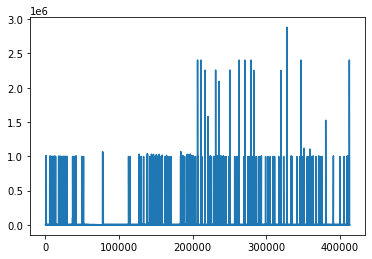

In [12]:
plt.plot(losses)

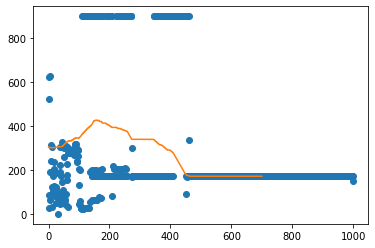

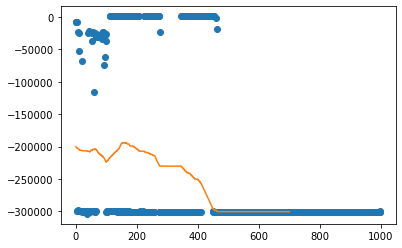

In [30]:
plt.figure()
plt.plot(durations, 'o')
plt.plot(np.convolve(durations, np.ones(300), 'valid') / 300)
plt.show()
plt.figure()
plt.plot(rewards, 'o')
plt.plot(np.convolve(rewards, np.ones(300), 'valid') / 300)
plt.show()

Simulation failed at learning step:  30


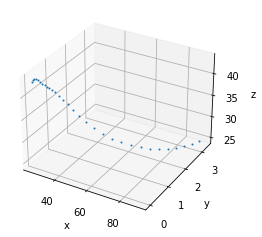

In [19]:
theta=[]
phi=[]
r=[]
net.eval()
visits=np.zeros((n_attack, n_bank,n_beta))
initial_position=pk.vect(np.pi/6, 0, 50)
initial_velocity=pk.vect(0, 0, 0)
wind=pk.vect(5,0,0)
k=pk.kite(initial_position, initial_velocity)
initial_beta=k.beta(wind)
S_t=(14,3,initial_beta)
for i in range(horizon):
    tensor_state=torch.tensor(S_t).float()
    q=net(tensor_state).reshape(3,3)
    #print(q)
    theta.append(k.position.theta)
    phi.append(k.position.phi)
    r.append(k.position.r)
    A_t=(q==torch.max(q)).nonzero().reshape(-1)
    A_t=A_t[0],A_t[1]
    #print(A_t)
    new_attack_angle, new_bank_angle=apply_action(S_t, A_t)
    status=k.evolve_system(new_attack_angle, new_bank_angle, integration_steps_per_learning_step, integration_step, wind)
    if not status==0:
        print("Simulation failed at learning step: ", i)
        break
    S_t = (new_attack_angle, new_bank_angle, k.beta(wind))
    visits[S_t]+=1
    if i==int(horizon)-1:
        print( "Simulation ended at learning step: ", i)

theta=np.array(theta)
phi=np.array(phi)
r=np.array(r)
plot_trajectory(theta, phi, r)
#print(visits)

In [32]:
Q=np.ones((n_attack, n_bank, n_beta, 3, 3))
for a in range(n_attack):
    for b in range(n_bank):
        Q[a,b,0]=net(torch.tensor([a,b,0]).float()).reshape(3,3).detach().numpy()
print(np.max(Q))
durations=[]
rewards=[]
eta0=.1
episodes=6000
t=0
for j in range(episodes):
    cumulative_reward=0
    initial_position=pk.vect(np.pi/6, 0, 50)
    initial_velocity=pk.vect(0, 0, 0)
    wind=pk.vect(5,0,0)
    k=pk.kite(initial_position, initial_velocity)
    initial_beta=k.beta(wind)
    S_t=(14,3,initial_beta)
    print(np.max(Q))
    for i in range(horizon):
        t+=1
        eps=scheduling(eps0, t, 200000)
        eta=scheduling(eta0, t, 500000)
        A_t=eps_greedy_policy(Q, S_t, eps)
        new_attack_angle, new_bank_angle=apply_action(S_t, A_t)
        sim_status=k.evolve_system(new_attack_angle, new_bank_angle, integration_steps_per_learning_step, integration_step, wind)
        if not sim_status==0:
            R_t1 = scheduling(-300000, i, horizon/4)
            cumulative_reward+=R_t1
            print(t, j, "Simulation failed at learning step: ", i, " reward ", cumulative_reward)
            rewards.append(cumulative_reward)
            durations.append(i)
            Q=terminal_step(Q, S_t, A_t, R_t1, eta)
            break
        S_t1 = (new_attack_angle, new_bank_angle, k.beta(wind))
        R_t1 = k.reward(new_attack_angle, new_bank_angle, wind)
        cumulative_reward+=R_t1
        A_t1=eps_greedy_policy(Q, S_t1, 0)
        if i==int(horizon)-1:
            Q=terminal_step(Q, S_t, A_t, R_t1, eta)
            print(j, "Simulation ended at learning step: ", i, " reward ", cumulative_reward)
            rewards.append(cumulative_reward)
            durations.append(i)
        else:
            Q=step(Q, S_t, A_t, R_t1, S_t1, A_t1, eta, gamma)
        S_t=S_t1
        #A_t=A_t1

3.502833843231201
3.502833843231201
325 0 Simulation failed at learning step:  324  reward  -16524.609360644412
167.77148388199038
699 1 Simulation failed at learning step:  373  reward  -12230.893593338498
488.432717436667
886 2 Simulation failed at learning step:  186  reward  -299375.44479428924
726.7410510008676
954 3 Simulation failed at learning step:  67  reward  -298969.60726838
726.7410510008676
957 4 Simulation failed at learning step:  2  reward  -299942.97810092836
726.7410510008676
1397 5 Simulation failed at learning step:  439  reward  -9555.613881297786
726.7410510008676
1586 6 Simulation failed at learning step:  188  reward  -297039.7525094182
726.7410510008676
1946 7 Simulation failed at learning step:  359  reward  -15289.921865485298
726.7410510008676
2056 8 Simulation failed at learning step:  109  reward  -299781.84162247647
726.7410510008676
2358 9 Simulation failed at learning step:  301  reward  -19758.228363485832
909.7365024344805
2916 10 Simulation failed a

KeyboardInterrupt: 